# Experimentation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
DATA_FILEPATH = Path("data", "input", "air_quality_health_impact_data.csv")
air = pd.read_csv(DATA_FILEPATH)

## Exploratory Data Analysis
This section is dedicated to understanding the data, identifying and correcting missing values, and examing distributions of features. Additionally, we will look at the covariance and correlation matrices to see if, visually, we can identify any basic trends in the data.

In [3]:
print(f"Observations: {air.shape[0]}")
print(f"Features: {air.shape[1]}")
air.head()

Observations: 5811
Features: 15


,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,7,5,1,97.244041,0.0
1,2,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,10,2,0,100.000000,0.0
2,3,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,13,3,0,100.000000,0.0
3,4,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,8,8,1,100.000000,0.0
4,5,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,9,0,1,95.182643,0.0


In [4]:
air.describe(include="all")

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
count,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000,5811.000000
mean,2906.000000,248.438476,148.654997,100.223714,102.293445,49.456838,149.312431,14.975500,54.776853,9.989177,9.974187,4.988986,2.001033,93.785223,0.281191
std,1677.635538,144.777638,85.698500,58.096612,57.713175,28.530329,86.534240,14.483067,26.020786,5.776950,3.129234,2.216791,1.398794,13.318904,0.714075
min,1.000000,0.005817,0.015848,0.031549,0.009625,0.011023,0.001661,-9.990998,10.001506,0.002094,1.000000,0.000000,0.000000,22.448488,0.000000
25%,1453.500000,122.951293,75.374954,49.435171,53.538538,24.887264,73.999665,2.481500,31.995262,4.952343,8.000000,3.000000,1.000000,98.203057,0.000000
50%,2906.000000,249.127841,147.634997,100.506337,102.987736,49.530165,149.559871,14.942428,54.543904,10.051742,10.000000,5.000000,2.000000,100.000000,0.000000
75%,4358.500000,373.630668,222.436759,151.340260,151.658516,73.346617,223.380126,27.465374,77.641639,14.971840,12.000000,6.000000,3.000000,100.000000,0.000000
max,5811.000000,499.858837,299.901962,199.984965,199.980195,99.969561,299.936812,39.963434,99.997493,19.999139,23.000000,14.000000,12.000000,100.000000,4.000000


In [5]:
air.isna().sum()

RecordID               0
AQI                    0
PM10                   0
PM2_5                  0
NO2                    0
SO2                    0
O3                     0
Temperature            0
Humidity               0
WindSpeed              0
RespiratoryCases       0
CardiovascularCases    0
HospitalAdmissions     0
HealthImpactScore      0
HealthImpactClass      0
dtype: int64

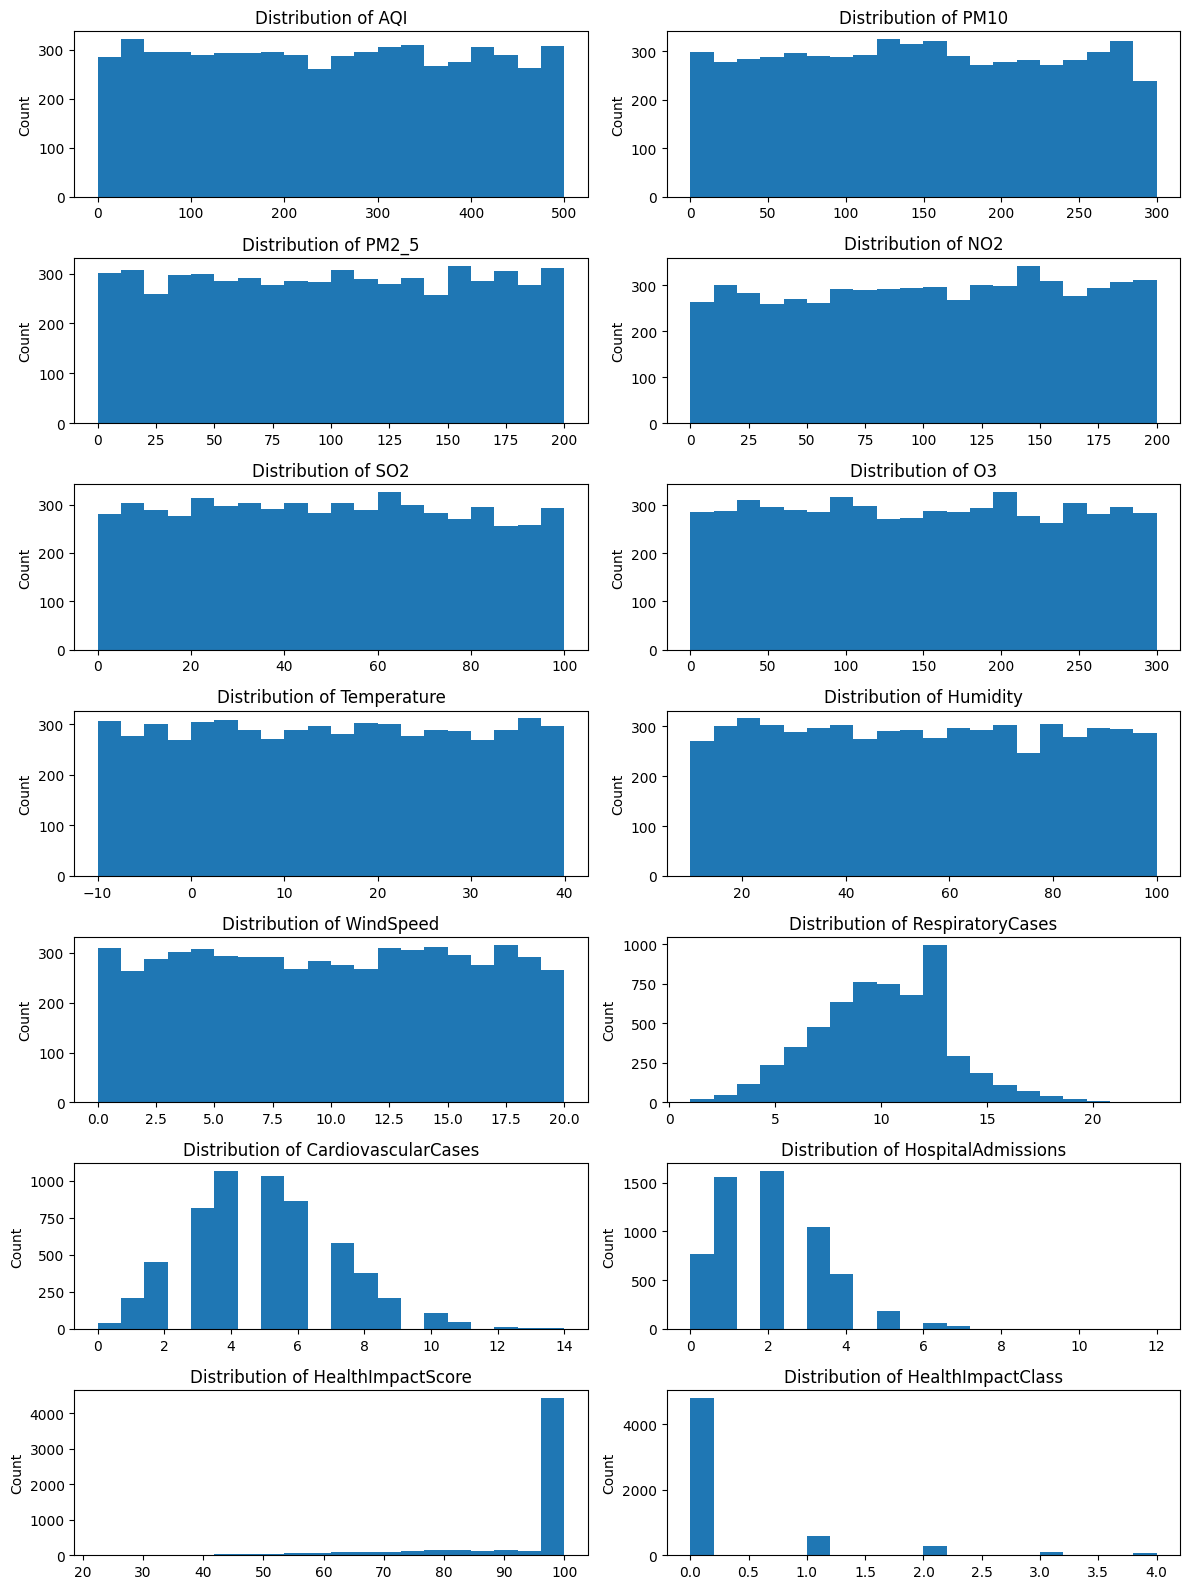

In [6]:
bins = 20

fig, axs = plt.subplots(7, 2, figsize=(12, 16))

axs[0, 0].hist(air["AQI"], bins=bins)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of AQI")

axs[0, 1].hist(air["PM10"], bins=bins)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of PM10")

axs[1, 0].hist(air["PM2_5"], bins=bins)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of PM2_5")

axs[1, 1].hist(air["NO2"], bins=bins)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of NO2")

axs[2, 0].hist(air["SO2"], bins=bins)
axs[2, 0].set_ylabel("Count")
axs[2, 0].set_title("Distribution of SO2")

axs[2, 1].hist(air["O3"], bins=bins)
axs[2, 1].set_ylabel("Count")
axs[2, 1].set_title("Distribution of O3")

axs[3, 0].hist(air["Temperature"], bins=bins)
axs[3, 0].set_ylabel("Count")
axs[3, 0].set_title("Distribution of Temperature")

axs[3, 1].hist(air["Humidity"], bins=bins)
axs[3, 1].set_ylabel("Count")
axs[3, 1].set_title("Distribution of Humidity")

axs[4, 0].hist(air["WindSpeed"], bins=bins)
axs[4, 0].set_ylabel("Count")
axs[4, 0].set_title("Distribution of WindSpeed")

axs[4, 1].hist(air["RespiratoryCases"], bins=bins)
axs[4, 1].set_ylabel("Count")
axs[4, 1].set_title("Distribution of RespiratoryCases")

axs[5, 0].hist(air["CardiovascularCases"], bins=bins)
axs[5, 0].set_ylabel("Count")
axs[5, 0].set_title("Distribution of CardiovascularCases")

axs[5, 1].hist(air["HospitalAdmissions"], bins=bins)
axs[5, 1].set_ylabel("Count")
axs[5, 1].set_title("Distribution of HospitalAdmissions")

axs[6, 0].hist(air["HealthImpactScore"], bins=bins)
axs[6, 0].set_ylabel("Count")
axs[6, 0].set_title("Distribution of HealthImpactScore")

axs[6, 1].hist(air["HealthImpactClass"], bins=bins)
axs[6, 1].set_ylabel("Count")
axs[6, 1].set_title("Distribution of HealthImpactClass")

plt.tight_layout()
plt.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

In [7]:
air.cov(numeric_only=True)

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
RecordID,2.814461e+06,-915.118912,3200.399420,2223.808131,1035.413064,-1030.214769,-126.868913,99.144126,-63.258729,179.575656,-76.355938,-113.566437,-19.474182,352.722989,237.470396
AQI,-9.151189e+02,20960.564345,286.946043,49.539708,65.470651,-27.442713,29.305340,8.774701,-15.886663,-15.736839,4.214200,2.939291,-2.752532,1185.042921,-35.987909
PM10,3.200399e+03,286.946043,7344.232946,-60.707189,41.974086,-17.547512,-32.708187,-21.796040,-38.555213,-9.386227,-0.352631,2.960180,-1.087933,208.421940,-6.625636
PM2_5,2.223808e+03,49.539708,-60.707189,3375.216298,18.656091,26.345030,30.515146,-1.663981,10.158317,3.034366,4.589278,2.229536,-1.879077,170.500729,-6.322664
NO2,1.035413e+03,65.470651,41.974086,18.656091,3330.810611,-32.897752,-74.464208,5.826643,-16.669793,-0.465958,3.584615,-0.641239,-0.230830,95.650252,-3.724970
SO2,-1.030215e+03,-27.442713,-17.547512,26.345030,-32.897752,813.979664,-10.663419,-9.279807,0.675913,-0.266439,0.993666,-0.169000,-0.420879,5.903036,-0.170395
O3,-1.268689e+02,29.305340,-32.708187,30.515146,-74.464208,-10.663419,7488.174751,-1.575763,8.965722,-1.297670,-2.726206,0.336205,-1.730023,182.032463,-6.802844
Temperature,9.914413e+01,8.774701,-21.796040,-1.663981,5.826643,-9.279807,-1.575763,209.759242,-0.087726,0.074175,0.425743,0.296936,0.160913,-2.036204,0.061735
Humidity,-6.325873e+01,-15.886663,-38.555213,10.158317,-16.669793,0.675913,8.965722,-0.087726,677.081285,3.160746,0.707629,-1.419961,-0.177061,0.229557,-0.124777
WindSpeed,1.795757e+02,-15.736839,-9.386227,3.034366,-0.465958,-0.266439,-1.297670,0.074175,3.160746,33.373151,-0.190772,0.047579,-0.052155,-1.957956,0.024747


A few examples of what we can find from the data here include:

1. The high covariance (286.94) of AQI and PM10 indicates that a higher AQI is associated with a higher level of particulates 10 µm or smaller.
2. The extremely high covariance (1185.04) between AQI and HealthImpactScore indicates that higher AQI is associated with a higher Health Impact Score.
3. The negative covariance between O3 and NO2 (-74.46) indicates that higher Ozone is associated with lower levels of nitrogen dioxide.

Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:


In [8]:
air.corr(numeric_only=True)

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
RecordID,1.000000,-0.003768,0.022260,0.022816,0.010694,-0.021524,-0.000874,0.004080,-0.001449,0.018529,-0.014545,-0.030537,-0.008299,0.015786,0.198229
AQI,-0.003768,1.000000,0.023127,0.005890,0.007836,-0.006644,0.002339,0.004185,-0.004217,-0.018816,0.009302,0.009158,-0.013592,0.614560,-0.348106
PM10,0.022260,0.023127,1.000000,-0.012193,0.008487,-0.007177,-0.004411,-0.017561,-0.017290,-0.018959,-0.001315,0.015582,-0.009076,0.182600,-0.108271
PM2_5,0.022816,0.005890,-0.012193,1.000000,0.005564,0.015894,0.006070,-0.001978,0.006720,0.009041,0.025244,0.017312,-0.023123,0.220347,-0.152407
NO2,0.010694,0.007836,0.008487,0.005564,1.000000,-0.019979,-0.014910,0.006971,-0.011100,-0.001398,0.019849,-0.005012,-0.002859,0.124435,-0.090387
SO2,-0.021524,-0.006644,-0.007177,0.015894,-0.019979,1.000000,-0.004319,-0.022458,0.000910,-0.001617,0.011130,-0.002672,-0.010546,0.015535,-0.008364
O3,-0.000874,0.002339,-0.004411,0.006070,-0.014910,-0.004319,1.000000,-0.001257,0.003982,-0.002596,-0.010068,0.001753,-0.014293,0.157940,-0.110093
Temperature,0.004080,0.004185,-0.017561,-0.001978,0.006971,-0.022458,-0.001257,1.000000,-0.000233,0.000887,0.009394,0.009249,0.007943,-0.010556,0.005969
Humidity,-0.001449,-0.004217,-0.017290,0.006720,-0.011100,0.000910,0.003982,-0.000233,1.000000,0.021027,0.008691,-0.024617,-0.004865,0.000662,-0.006715
WindSpeed,0.018529,-0.018816,-0.018959,0.009041,-0.001398,-0.001617,-0.002596,0.000887,0.021027,1.000000,-0.010553,0.003715,-0.006454,-0.025447,0.005999


## Preprocessing

This section will define and utilize functions to split the data into training, validation, and test splits. Additionally, we will create preprocessing steps to scale the data by removing the mean and dividing by the standard deviation. This returns us a feature centered around 0, making learning easier.

### Function Declarations

In [9]:
import joblib
import tarfile
import tempfile
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer


def preprocess(base_directory, job_type="classification"):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)
    df = df.drop(df.columns[0], axis=1)

    if job_type == "classification":
        target_transformer = ColumnTransformer(
            transformers=[
                ("Class", FunctionTransformer(np.abs), ["HealthImpactClass"])
            ],
        )
    else:
        target_transformer = ColumnTransformer(
            transformers=[("Score", StandardScaler(), ["HealthImpactScore"])],
        )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    y_train = target_transformer.fit_transform(df_train)
    y_validation = target_transformer.transform(df_validation)
    y_test = target_transformer.transform(df_test)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    df_train = df_train.drop("HealthImpactClass", axis=1)
    df_validation = df_validation.drop("HealthImpactClass", axis=1)
    df_test = df_test.drop("HealthImpactClass", axis=1)

    df_train = df_train.drop("HealthImpactScore", axis=1)
    df_validation = df_validation.drop("HealthImpactScore", axis=1)
    df_test = df_test.drop("HealthImpactScore", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("HealthImpactClass", axis=1)
    df = df.drop("HealthImpactScore", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """

    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib",
                arcname="features.joblib",
            )

In [10]:
base_directory = Path("data")
preprocess(base_directory, job_type="classification")

## Model Training

This section will define and test the model using the sklearn library. Different models will be used, and different hyperparameters will be tested in order to try to find the best configuration for performance.

### XGBoost
This first section will examine XGBoost, a popular machine learning framework for regression and classification tasks.

In [12]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

train_path = Path(base_directory, "train")
X_train = pd.read_csv(Path(train_path, "train.csv"), header=None)
y_train = X_train[X_train.columns[-1]]
X_train = X_train.drop(X_train.columns[-1], axis=1)

val_path = Path(base_directory, "validation")
X_val = pd.read_csv(Path(val_path, "validation.csv"), header=None)
y_val = X_val[X_val.columns[-1]]
X_val = X_val.drop(X_val.columns[-1], axis=1)

# Define the hyperparameters and their search ranges
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
}

# Create an XGBoost model
xgb_model = xgb.XGBClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [13]:
best_params["early_stopping_rounds"] = 10
# Fit the model with the best hyperparameters on the entire dataset
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-mlogloss:1.25211
[1]	validation_0-mlogloss:1.03015
[2]	validation_0-mlogloss:0.87223
[3]	validation_0-mlogloss:0.75688
[4]	validation_0-mlogloss:0.66775
[5]	validation_0-mlogloss:0.59627
[6]	validation_0-mlogloss:0.54092
[7]	validation_0-mlogloss:0.49703
[8]	validation_0-mlogloss:0.45948
[9]	validation_0-mlogloss:0.43014
[10]	validation_0-mlogloss:0.40630
[11]	validation_0-mlogloss:0.38817
[12]	validation_0-mlogloss:0.37206
[13]	validation_0-mlogloss:0.36103
[14]	validation_0-mlogloss:0.35050
[15]	validation_0-mlogloss:0.34199
[16]	validation_0-mlogloss:0.33409
[17]	validation_0-mlogloss:0.32783
[18]	validation_0-mlogloss:0.32405
[19]	validation_0-mlogloss:0.32041
[20]	validation_0-mlogloss:0.31534
[21]	validation_0-mlogloss:0.31319
[22]	validation_0-mlogloss:0.31169
[23]	validation_0-mlogloss:0.30928
[24]	validation_0-mlogloss:0.30731
[25]	validation_0-mlogloss:0.30522
[26]	validation_0-mlogloss:0.30408
[27]	validation_0-mlogloss:0.30380
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [14]:
test_path = Path(base_directory, "test")
X_test = pd.read_csv(Path(test_path, "test.csv"), header=None)
y_test = X_test[X_test.columns[-1]]
X_test = X_test.drop(X_test.columns[-1], axis=1)

# Evaluate the best model on the test set
accuracy = best_model.score(X_test, y_test)

print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.90


[0.24600692 0.0917137  0.11721393 0.08162772 0.0560419  0.09575383
 0.0551345  0.05134367 0.05204776 0.05366926 0.04722265 0.05222416]


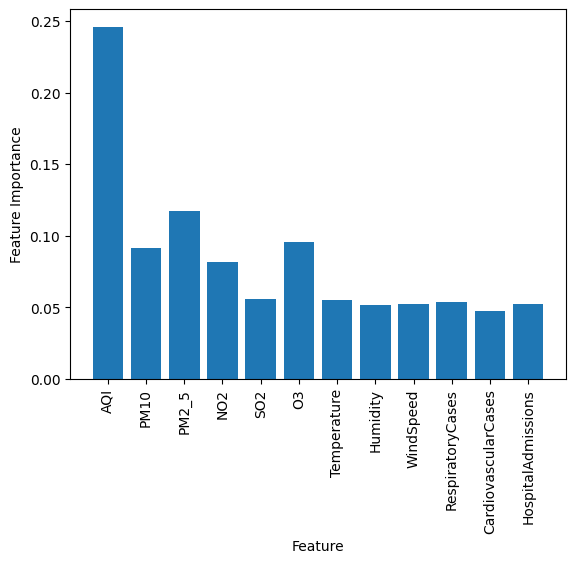

In [31]:
# feature importance
print(best_model.feature_importances_)
# plot
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.xlabel("Feature")
plt.xticks(range(len(best_model.feature_importances_)), air.columns[1:13], rotation=90)
plt.ylabel("Feature Importance")
plt.show()

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_train)

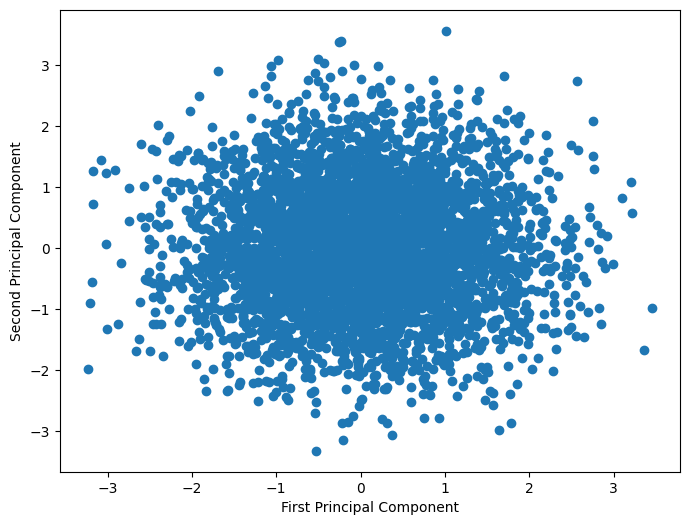

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

In [33]:
model = xgb.XGBClassifier()
model.fit(X_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
X_pca_test = pca.transform(X_test)
accuracy = model.score(X_pca_test, y_test)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.82
